In [11]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

from collections import defaultdict
from functools import partial
import os

from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
%matplotlib inline

In [3]:
log_dir = os.path.join(os.getcwd(), "../.runs/seq_multiseed/cifar10")

In [4]:
experiments = os.listdir(log_dir)
experiments

['sgd_1_of_2',
 'mfvi_1_of_2',
 'mfvi_2_of_2',
 'sgd_2_of_2_from_split1_init',
 'sgd_2_of_2_stratified_from_split1_init',
 'sgd_2_of_2_stratified',
 'sgd_2_of_2',
 'mfvi_1_of_2_stratified',
 'mfvi_2_of_2_stratified',
 'sgd_1_of_2_stratified']

In [4]:
experiment = "sgd_1_of_2"

In [5]:
def parse_sgd_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    return df.drop(columns=['command']).astype(float)

In [6]:
def load_sgd_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_sgd_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [7]:
df_sgd_split1 = load_sgd_experiment_logs("sgd_1_of_2")
# df_sgd_split2 = load_sgd_experiment_logs("sgd_2_of_2")
df_sgd_split2_from_split1_init = load_sgd_experiment_logs(
    "sgd_2_of_2_from_split1_init",
    # experiment_instance="sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_1",
    # events_log="events.out.tfevents.1727565335.garchie.32121.0.v2"
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


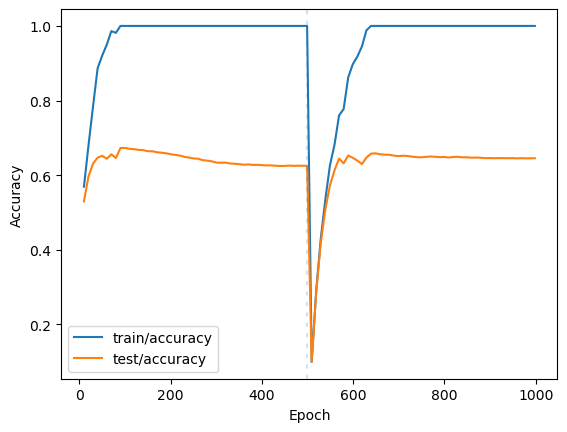

In [8]:
pd.concat([
    df_sgd_split1,#.rolling(20, min_periods=1).mean(),
    df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),#.rolling(20, min_periods=1).mean()
])[['train/accuracy', 'test/accuracy']].plot()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.axvline(x=df_sgd_split1.index.max(), ymin=0, ymax=1, alpha=0.2, dashes=(2,3))

In [9]:
df_sgd_split1_stratified = load_sgd_experiment_logs("sgd_1_of_2_stratified")
df_sgd_split2_stratified_from_split1_init = load_sgd_experiment_logs("sgd_2_of_2_stratified_from_split1_init")

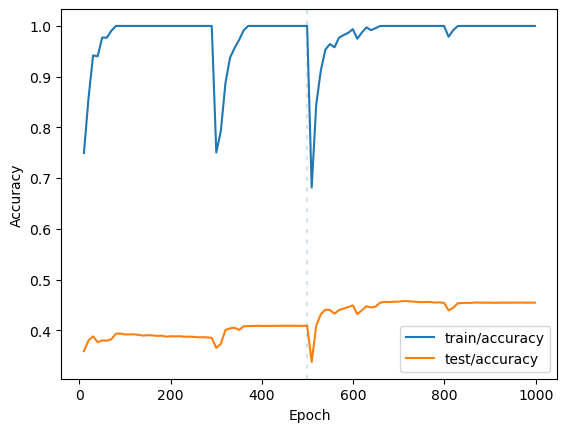

In [10]:
pd.concat([
    df_sgd_split1_stratified,
    df_sgd_split2_stratified_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1_stratified.index.max()).set_index("step"),
])[['train/accuracy', 'test/accuracy']].plot()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.axvline(x=df_sgd_split1_stratified.index.max(), ymin=0, ymax=1, alpha=0.2, dashes=(2,3))

In [7]:
def parse_mfvi_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    # TODO generate insights from sigma histograms
    return df.drop(columns=['command', 'MFVI/param_stds']).astype(float)
def load_mfvi_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_mfvi_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [16]:
df_mfvi_split1 = load_mfvi_experiment_logs("mfvi_1_of_2")
df_mfvi_split2 = load_mfvi_experiment_logs(
    "mfvi_2_of_2",
    # experiment_instance="mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_2913792_batchsize_80_temp_1.0__seed_0",
)
df_mfvi = load_mfvi_experiment_logs(
    "../../vi/cifar10/test",
    experiment_instance="mfvi_initsigma_0.01__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_11",
    events_log="events.out.tfevents.1726942795.garchie.30517.0.v2"
)

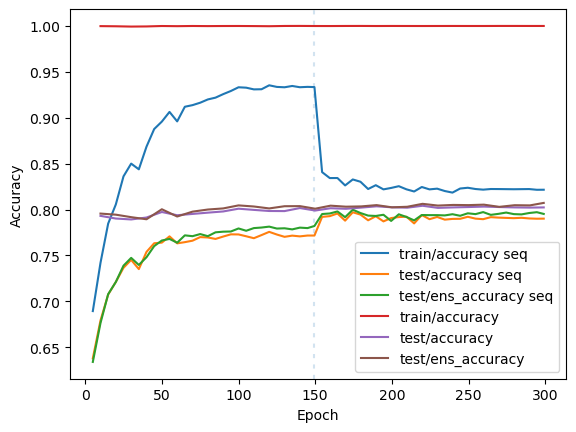

In [17]:
fig, ax = plt.subplots()
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])[['train/accuracy', 'test/accuracy', 'test/ens_accuracy']].add_suffix(" seq")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
df_mfvi[['train/accuracy', 'test/accuracy', 'test/ens_accuracy']].plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
plt.show()

In [18]:
df_mfvi_split1_stratified = load_mfvi_experiment_logs("mfvi_1_of_2_stratified")
df_mfvi_split2_stratified = load_mfvi_experiment_logs(
    "mfvi_2_of_2_stratified",
    # experiment_instance="mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_7794560_batchsize_80_temp_1.0__seed_0",
)

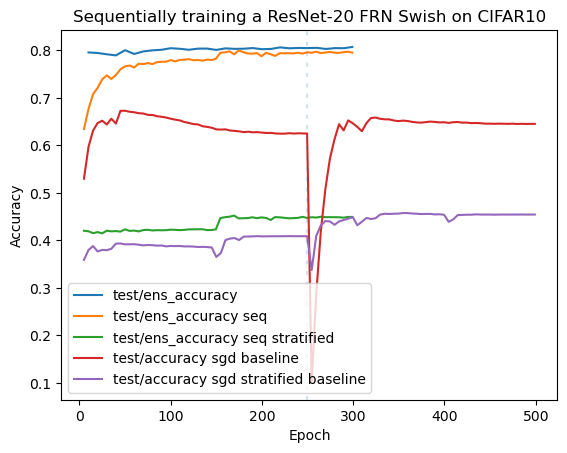

In [19]:
fig, ax = plt.subplots()
FIELDS_TO_PLOT = [
    # "test/accuracy",
    "test/ens_accuracy"
]
SGD_FIELDS_TO_PLOT = [
    "test/accuracy"
]
ADD_SGD_BASELINE = True
# Plot all-in-one-go training
df_mfvi[FIELDS_TO_PLOT].plot(ax=ax)
# Plot randomized sequential training
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])[FIELDS_TO_PLOT].add_suffix(" seq")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
# Plot stratified sequential training
seq_plot_df = pd.concat([
    df_mfvi_split1_stratified,
    df_mfvi_split2_stratified.reset_index().assign(step=lambda df: df.step+df_mfvi_split1_stratified.index.max()).set_index("step"),
])[FIELDS_TO_PLOT].add_suffix(" seq stratified")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1,
        df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
    ])[SGD_FIELDS_TO_PLOT].add_suffix(" sgd baseline")
    seq_plot_df.index /= 2.0
    seq_plot_df.plot(ax=ax)
    # Add SGD stratified baseline
    seq_plot_df = pd.concat([
        df_sgd_split1_stratified,
        df_sgd_split2_stratified_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1_stratified.index.max()).set_index("step"),
    ])[SGD_FIELDS_TO_PLOT].add_suffix(" sgd stratified baseline")
    seq_plot_df.index /= 2.0
    seq_plot_df.plot(ax=ax)
# Format figure
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Sequentially training a ResNet-20 FRN Swish on CIFAR10")
# fig.savefig("plots/seq_mfvi_sgd_baseline_seed1.png", dpi=500)
plt.show()

## Repro SGD & VI baseline

In [8]:
def winsorize(xs: pd.Series, q_low=0., q_high=1.):
    return xs.clip(*xs.quantile([q_low, q_high]))

def rolling_median(xs, window=5, centred=False):
    return xs.rolling(window, min_periods=2).median()

In [9]:
def plot_agg(df, ax, label):
    ax.plot(df.index, df['mean'], label=label)
    ax.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], alpha=0.3)

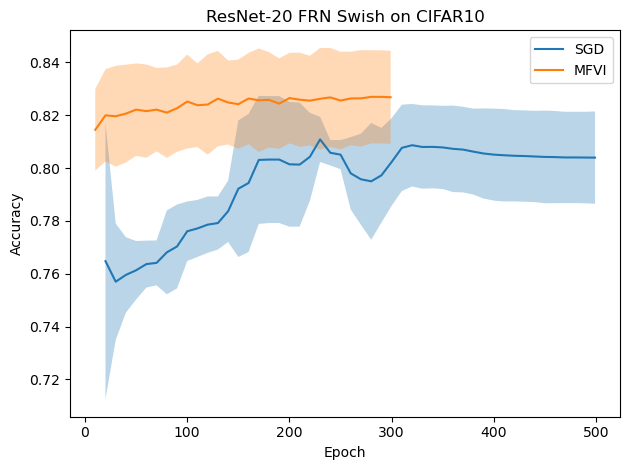

In [13]:
fig, ax = plt.subplots()

SEEDS = range(1, 3+1)
df_sgd_nonseq = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../multiseed/sgd/cifar10",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])
# df_sgd_nonseq['test/accuracy'].unstack("seed").apply(winsorize, q_low=0.0).plot()
df_sgd_nonseq.apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]).pipe(lambda df: plot_agg(df, ax=ax, label="SGD"))
SEEDS = range(1, 3+1)
df_mfvi_nonseq = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../multiseed/vi/cifar10",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])
# df_mfvi_nonseq['test/accuracy'].unstack("seed").apply(winsorize, q_low=0.0).plot()
df_mfvi_nonseq.groupby(level="step")['test/accuracy'].agg(['mean', 'std']).pipe(lambda df: plot_agg(df, ax=ax, label="MFVI"))
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_title("ResNet-20 FRN Swish on CIFAR10")
fig.tight_layout()
# fig.savefig("plots/nonseq_seed1-3.png", dpi=500)
plt.show()

## Sequential VI

In [ ]:
SEEDS = range(1, 3+1)
df_mfvi_split1 = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_1_of_2",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"]).groupby(level="step")['test/accuracy'].agg(['mean', 'std'])
df_mfvi_split2 = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_2_of_2",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_{pretrain_hex}_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed, pretrain_hex in zip(SEEDS, [7069824, 7235200, 5441280])
}, names=["seed", "step"]).groupby(level="step")['test/accuracy'].agg(['mean', 'std'])
df_sgd_split1 = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_1_of_2",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"]).apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)])
df_sgd_split2_from_split1_init = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_2_of_2_from_split1_init",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"]).apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)])

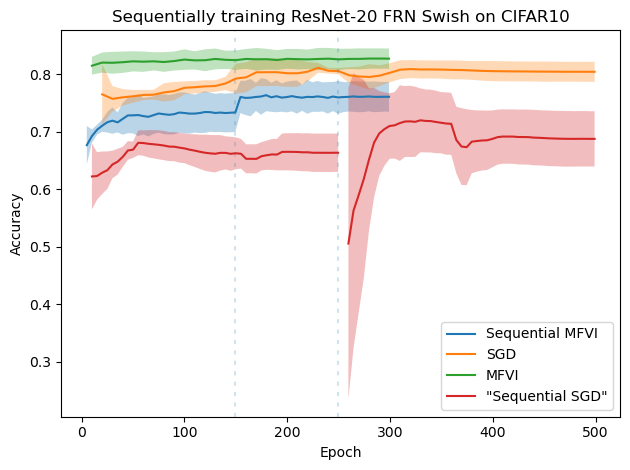

In [ ]:
fig, ax = plt.subplots()
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
plot_agg(seq_plot_df, ax=ax, label="Sequential MFVI")
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
plot_agg(df_sgd_nonseq.apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]), ax=ax, label="SGD")
plot_agg(df_mfvi_nonseq.groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]), ax=ax, label="MFVI")
ADD_SGD_BASELINE = True
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1,
        df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
    ])
    seq_plot_df.index /= 2.0
    plot_agg(seq_plot_df, ax=ax, label='"Sequential SGD"')
    ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
ax.legend(loc='lower right')
fig.tight_layout()
# fig.savefig("plots/seq_mfvi_random_split_with_baseline_seed1-3.png", dpi=500)
plt.show()

In [29]:
# Same but for the stratified experiment
SEEDS = range(1, 3+1)
df_mfvi_split1_stratified = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_1_of_2_stratified",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"]).groupby(level="step")['test/accuracy'].agg(['mean', 'std'])
df_mfvi_split2_stratified = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_2_of_2_stratified",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_{pretrain_hex}_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed, pretrain_hex in zip(SEEDS, [276224, 2256096, 3312512])
}, names=["seed", "step"]).groupby(level="step")['test/accuracy'].agg(['mean', 'std'])
df_sgd_split1_stratified = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_1_of_2_stratified",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"]).apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)])
# df_sgd_split2_stratified_from_split1_init = pd.concat({
#     seed: load_sgd_experiment_logs(
#         "../../seq_multiseed/cifar10/sgd_2_of_2_stratified_from_split1_init",
#         experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_pretr_{pretrain_hex}_batchsize_80_temp_1.0__seed_{seed}"
#     )
#     for seed in SEEDS
# }, names=["seed", "step"]).apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)])


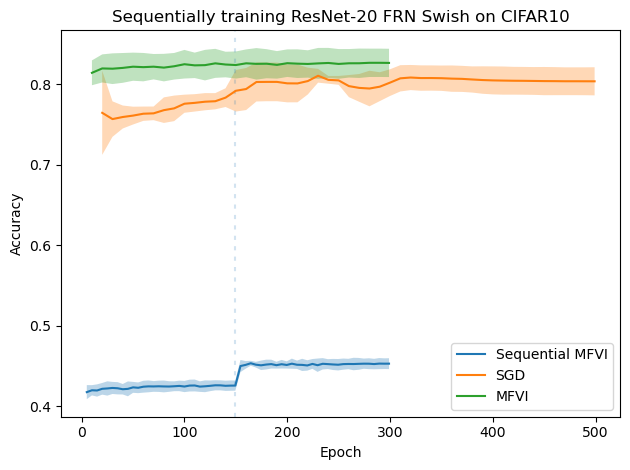

In [ ]:
fig, ax = plt.subplots()
seq_plot_df = pd.concat([
    df_mfvi_split1_stratified,
    df_mfvi_split2_stratified.reset_index().assign(step=lambda df: df.step+df_mfvi_split1_stratified.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
plot_agg(seq_plot_df, ax=ax, label="Sequential MFVI (stratified)")
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
plot_agg(df_sgd_nonseq.apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]), ax=ax, label="SGD")
plot_agg(df_mfvi_nonseq.groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]), ax=ax, label="MFVI")
ADD_SGD_BASELINE = False
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1_stratified,
        df_sgd_split2_stratified_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
    ])
    seq_plot_df.index /= 2.0
    plot_agg(seq_plot_df, ax=ax, label='"Sequential SGD" (stratified)')
    ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
ax.legend(loc='lower right')
fig.tight_layout()
# fig.savefig("plots/seq_mfvi_stratified_split_with_baseline_seed1-3.png", dpi=500)
plt.show()